In [1]:
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

Датасет состоит из 15 205 фоток, всего 33 класса 
Распределение тренировочные/валидационные 80/20

In [2]:
# указываем параметры
batch_size = 32
img_size = 256
val_split = 0.2
# путь к датасету
Way_Dataset = r'New_Dataset'

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    validation_split=val_split,
)
val_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    validation_split=val_split,
)
# Считываем датасет, указываем подмножество training
train_generator = train_datagen.flow_from_directory(
    Way_Dataset,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)
# Считываем датасет, указываем подмножество validation
val_generator = val_datagen.flow_from_directory(
    Way_Dataset,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)

Found 12177 images belonging to 33 classes.
Found 3028 images belonging to 33 classes.


Архитектура нейронной сети

In [3]:
model = tf.keras.models.Sequential([
    Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(33, activation='softmax')
])
# вывод параметров
model.summary()

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

D:\Project\CNN\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 16)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 33)             │         4,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,557,345 (25.01 MB)

 Trainable params: 6,557,345 (25.01 MB)

 Non-trainable params: 0 (0.00 B)

Обучение нейронной сети, модель используемая в интерфейсе обучена при 40 эпохах

In [5]:
epochs = 20
# чекпоинты и ранняя остановка
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f'model.keras', monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=10, verbose=1)
]
# обучение
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=my_callbacks
)

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.0700 - loss: 3.4052
Epoch 1: val_loss improved from inf to 2.19501, saving model to model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 192s 499ms/step - accuracy: 0.0702 - loss: 3.4044 - val_accuracy: 0.4171 - val_loss: 2.1950
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.2973 - loss: 2.4439
Epoch 2: val_loss improved from 2.19501 to 1.78822, saving model to model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 139s 363ms/step - accuracy: 0.2974 - loss: 2.4436 - val_accuracy: 0.5469 - val_loss: 1.7882
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.4065 - loss: 2.1100
Epoch 3: val_loss improved from 1.78822 to 1.54512, saving model to model.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 145s 380ms/step - accuracy: 0.4066 - loss: 2.1099 - val_accuracy: 0.6295 - val_loss: 1.5451
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4614 - loss: 1.9778
Epoch 4: val_loss improved from 1.54512 to 1.4903

Вывод графиков

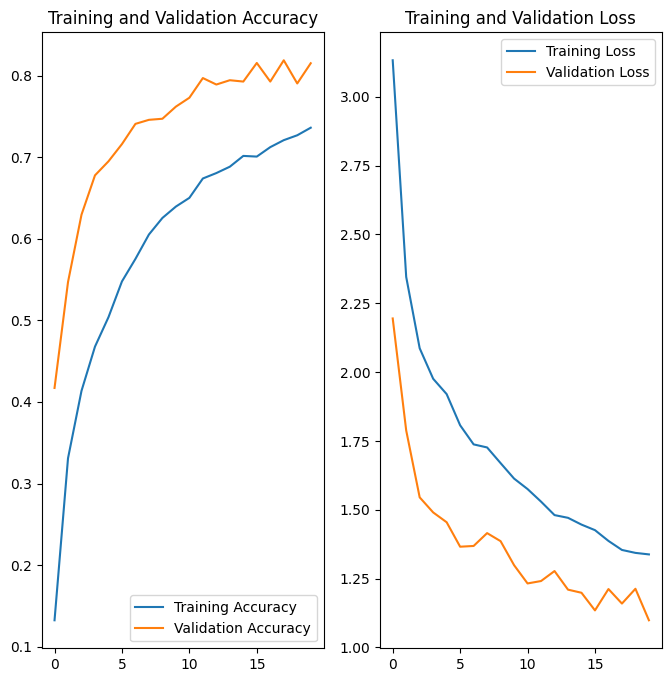

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()